<a href="https://colab.research.google.com/github/Shashank123-hub/MachineLearning/blob/master/Cats_and_dogs_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model 3 : Cats and  dogs with transfer learning**

This is the third model which involves classifying images of cats and dogs using ***Transfer Learning***. By doing so, we would drastically increase the accuracy of our model.

We'll import a already trained existing model from the ***TensorFlow Hub*** and other thing we'll do is cahnging the output/final layer of the training model.

# **Step 1 : Importing dependancies**

Importing all dependancies like tensorflow, pyplot, matplotlib etc.

In [0]:
import tensorflow as tf

In [0]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# **Step 2 : Download the classifier**

Donload the MobileNet model and create a Keras model from it. MobileNet works on 224 * 224 pixels, in 3 color channels(RGB).

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

# Step 2(a) : Running on a single image

MobileNet has been trained on ImageNet dataset. ImageNet has 1000 different output calsses, and one of them is military uniforms.

***This is just a testing block to check if the model is working or not.***



65536/61306 [================================] - 0s 0us/step


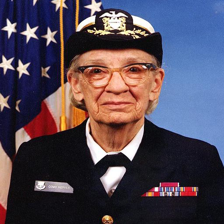

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [9]:
predicted_class = np.argmax(result[0], axis = -1)
predicted_class

653

**Pedicting the single image to check the working of the model**

16384/10484 [==============================================] - 0s 0us/step


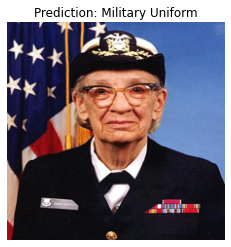

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# **Step 3 : Using TensorFlow Hub models for Cats vs. Dogs datset**

In [11]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteXC0PXY/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


**Printing the size of images**

In [12]:
for i, example_image in enumerate(train_examples.take(3)):
  print('Image {} shape: {}'.format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


**Reformatting the images to the resoltuion expected by MobileNet**

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

**Running the classifier on a batch of images(On different cats and dogs images)**

By default, our model already knows different class of cats and dogs since it has been pre-trained on the dataset.

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['tiger cat', 'Egyptian cat', 'tabby', 'bluetick', 'tabby',
       'Labrador retriever', 'Border collie', 'Great Dane',
       'Chesapeake Bay retriever', 'Bernese mountain dog', 'tabby',
       'tabby', 'Shetland sheepdog', 'tabby', 'Norwegian elkhound',
       'Persian cat', 'Egyptian cat', 'Egyptian cat', 'tabby',
       'Siamese cat', 'dalmatian', 'tabby', 'Siamese cat', 'Egyptian cat',
       'Weimaraner', 'web site', 'basset', 'Egyptian cat',
       'Rhodesian ridgeback', 'Labrador retriever', 'Brittany spaniel',
       'tabby'], dtype='<U30')

**Printing the ImageNet predictions on cats and dogs images**

Here, we are printing the each prediction made by ImageNet on each image od cats and dogs.

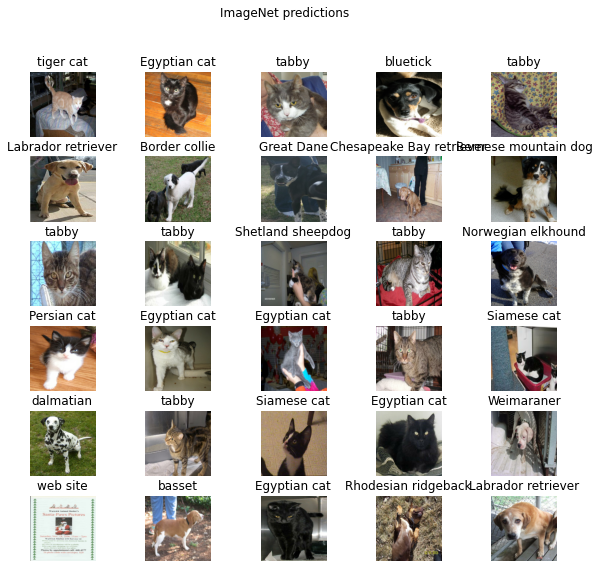

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")


# **Step 4 : Using transfer learning for training and classification**

Firstly, we'll import partial model from TensorFlow Hub and again use Dogs and Cats dataset to train our model.

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape = (IMAGE_RES, IMAGE_RES,3))

In [17]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor.trainable = False

# **Step 5 : Attach a classification head to the existing model**

Here, we are attaching a classification head to the pre-existing model so that trasfer learning can be done succesfully

In [19]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()   #Summarizing the whole model i.e each and every layer in it.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# **Step 6 : Training the model**

We'll train the model like any other by using fit method

In [20]:
model.compile(
  optimizer='adam',   #Optimizer for loss redundancy
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])   #Defining that our model is based on the accuracy 

EPOCHS = 6  #Means the data will be trained for 6 cycles total 
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 42s 72ms/step - loss: 0.0554 - accuracy: 0.9804 - val_loss: 0.0308 - val_accuracy: 0.9893
Epoch 2/6
582/582 [==============================] - 41s 71ms/step - loss: 0.0297 - accuracy: 0.9902 - val_loss: 0.0297 - val_accuracy: 0.9905
Epoch 3/6
582/582 [==============================] - 41s 71ms/step - loss: 0.0252 - accuracy: 0.9910 - val_loss: 0.0385 - val_accuracy: 0.9880
Epoch 4/6
582/582 [==============================] - 41s 71ms/step - loss: 0.0213 - accuracy: 0.9926 - val_loss: 0.0307 - val_accuracy: 0.9910
Epoch 5/6
582/582 [==============================] - 41s 71ms/step - loss: 0.0191 - accuracy: 0.9933 - val_loss: 0.0310 - val_accuracy: 0.9910
Epoch 6/6
582/582 [==============================] - 41s 70ms/step - loss: 0.0170 - accuracy: 0.9944 - val_loss: 0.0299 - val_accuracy: 0.9912


# **Step 7 : Printing out the final result i.e accuracy and losses for our model**

We'll plot the respective plots for each accuracy and losses for both validation and  taining dataset using ***matplotlib***.

Also, we can see that our model has achieved ~97% accuracy which is pretty effective as compared to previous models(without Transfer Learning). 

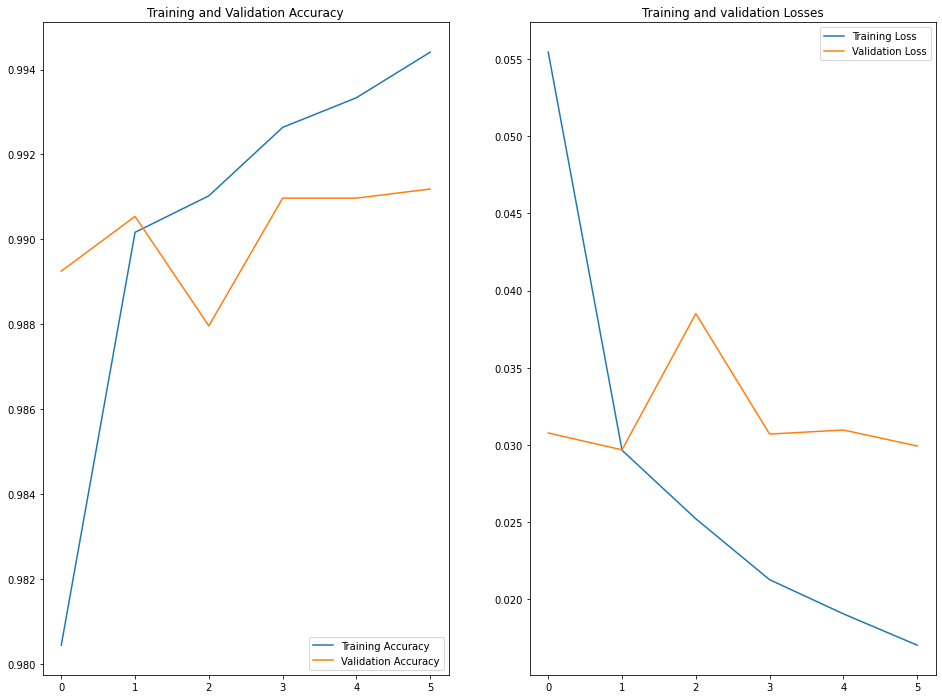

In [36]:
acc = history.history['accuracy']    #Defining accuracy variables.
val_acc =history.history['val_accuracy']

loss = history.history['loss']    #Defining loss variables.
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16,12))   #Defining the size of our figures.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')  #Metrics for accuracy model.
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')  
plt.legend(loc = 'lower right')  
plt.title('Training and Validation Accuracy')  #Title for our plot.

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')   #Metrics for loss model.
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation Losses')   #Title for our second plot.
plt.show()